# Import all the libraries

In [138]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.preprocessing import *
from sklearn.linear_model import *

import matplotlib.pyplot as plt
from darts import *
from darts.dataprocessing.transformers import *
from darts.models import *
from darts.metrics import *
from darts.datasets import *
from darts.utils.statistics import *
from darts.utils.timeseries_generation import *
from darts.utils.missing_values import fill_missing_values
from backtesting.test import EURUSD


# Load the TimeSeries dataframe

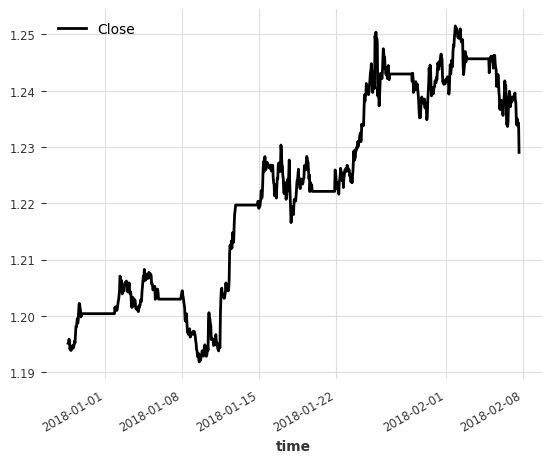

In [139]:
data = EURUSD.copy()
data = data[['Close']]
# extract only the last 1 month of data
data = data.iloc[-24*7*4:]

# data.plot()
eur_usd_series = TimeSeries.from_dataframe(data, value_cols=['Close'], freq='H',fill_missing_dates=True)
eur_usd_series = fill_missing_values(eur_usd_series, method="ffill", limit_direction="forward")
eur_usd_series.plot()

# Classical Models

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.34%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.68%


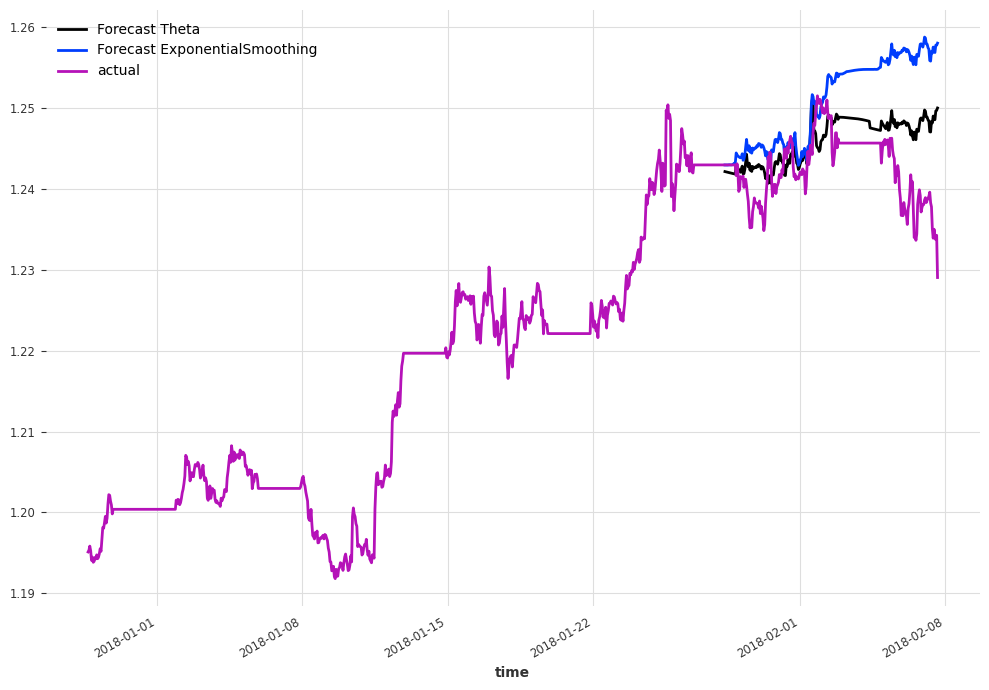

In [153]:
train, val = eur_usd_series.split_before(0.75)

models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    # "LinearRegression": LinearRegressionModel(lags=24*7),
    # "BayesianRidge": RegressionModel(lags=24*7, model=BayesianRidge()),
    # "XGBModel": XGBModel(lags=24*7),
    # "LightGBMModel": LightGBMModel(lags=24*7),
#     "DriftSeasonalEnsemble": RegressionEnsembleModel(
#     forecasting_models=[NaiveDrift(), NaiveSeasonal(24*7)], 
#     regression_train_n_points=200
# ),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast.plot(label="Forecast {}".format(name))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models With MinMaxScaler

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.32%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.66%
Training model LinearRegression
model LinearRegression() obtains MAPE: 0.76%


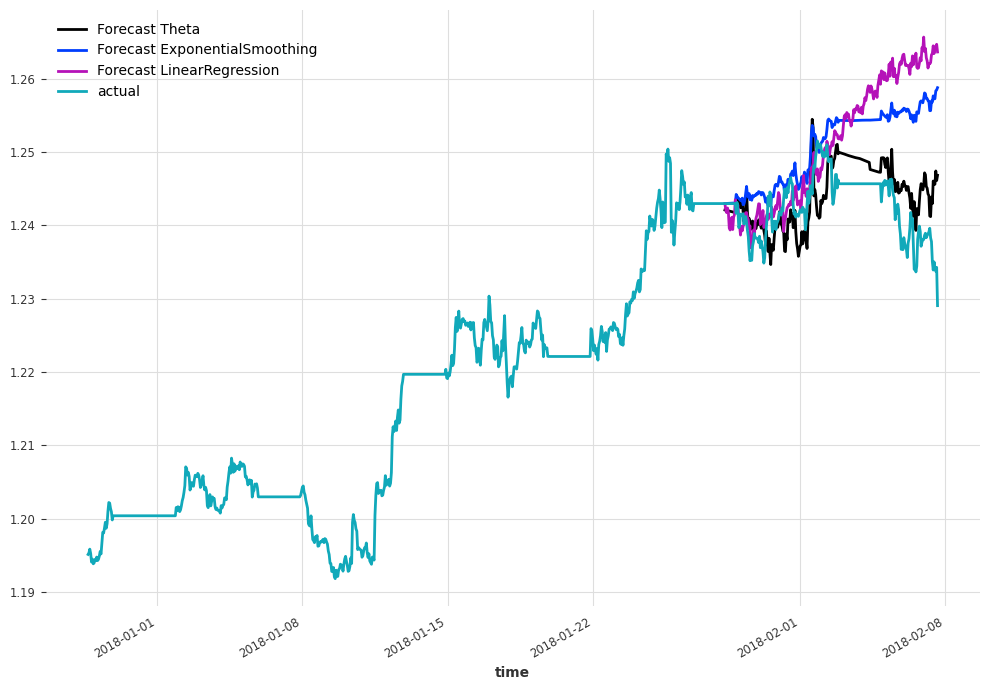

In [141]:
train, val = eur_usd_series.split_before(0.75)

transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models with PowerTransformer

Training model Theta
model Theta(seasonality_period=168) obtains MAPE: 0.48%
Training model ExponentialSmoothing
model ExponentialSmoothing(seasonal_periods=168) obtains MAPE: 0.30%
Training model LinearRegression
model LinearRegression() obtains MAPE: 1.06%


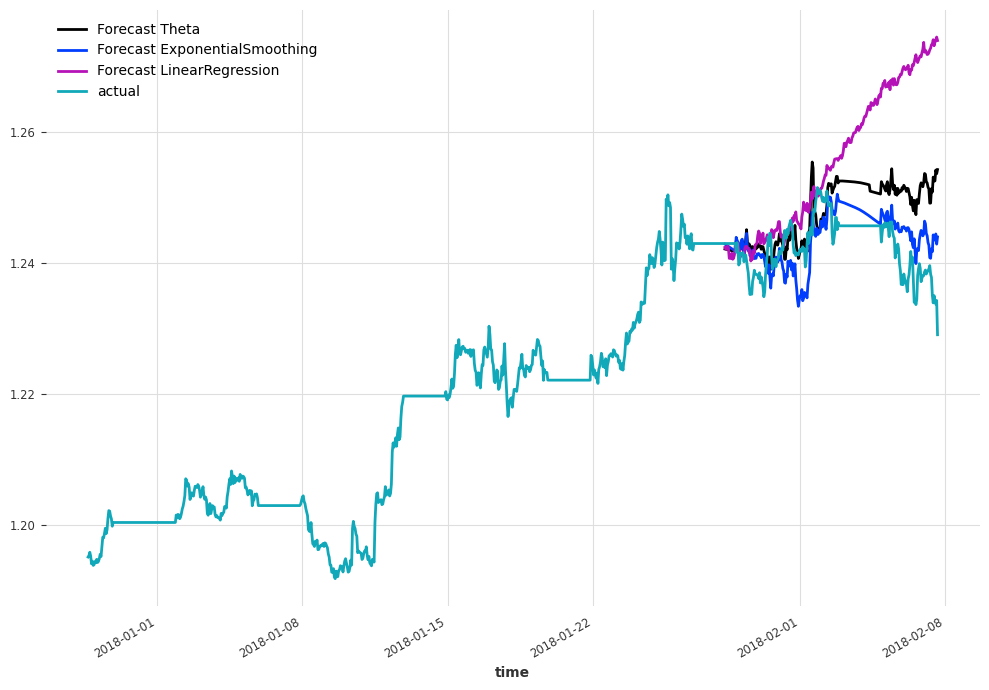

In [142]:
train, val = eur_usd_series.split_before(0.75)

transformer = BoxCox()
train = transformer.fit_transform(train)
val = transformer.transform(val)


models = {
    "Theta": Theta(seasonality_period=24*7),
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=24*7),
    "LinearRegression": LinearRegressionModel(lags=24*7),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))
    
    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")  
fig.tight_layout()
plt.show()

# Classical Models with GridSearch Param Optimization

Training model XGBoost
model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...) obtains MAPE: 0.27%


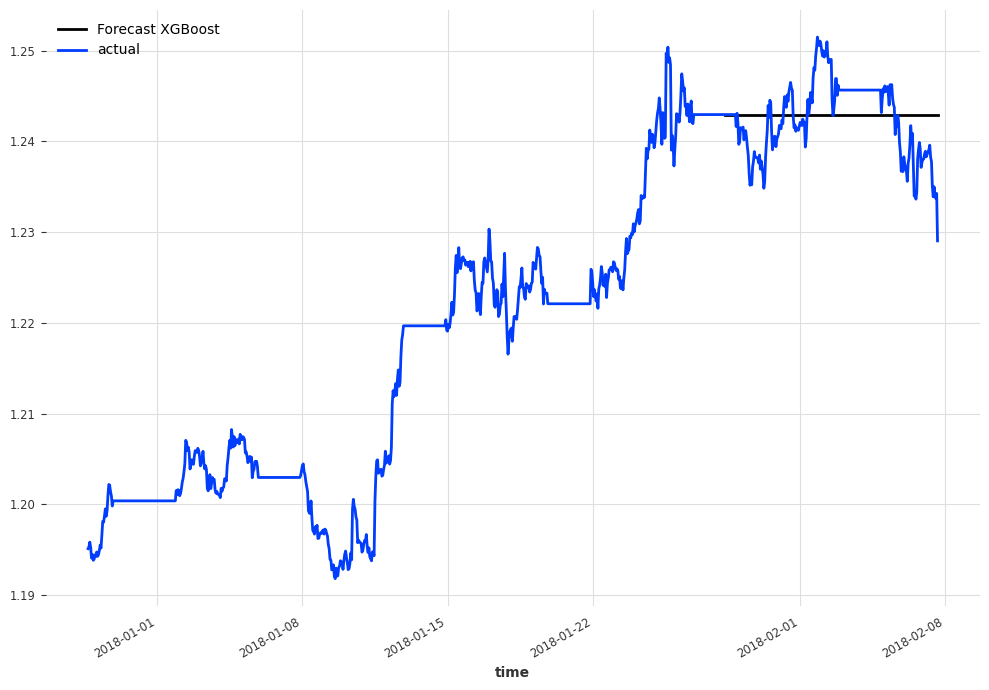

In [143]:
train, val = eur_usd_series.split_before(0.75)

transformer = BoxCox()
train = transformer.fit_transform(train)
val = transformer.transform(val)

# theta_optim = Theta.gridsearch(
#     parameters={
#         'seasonality_period': [24*7,24*7*2]
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]

# exponential_smoothing_optim = ExponentialSmoothing.gridsearch(
#     parameters={
#         'seasonal_periods': [24*7]
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]

# linear_regression_optim = LinearRegressionModel.gridsearch(
#     parameters={
#         'lags': [24*7],
#     },
#     series=train,
#     metric=mape,
#     forecast_horizon=len(val),
#     start=None,
# )[0]


# print(linear_regression_optim)

models = {
    # "Theta": Theta(seasonality_period=24*7),
    # 'Transformer': TransformerModel(
    #     input_chunk_length=24*7,
    #     output_chunk_length=24*2,
    #     log_tensorboard=True,
    #     random_state=42,
    #     n_epochs = 2,
    # ),
    # "ExponentialSmoothing": exponential_smoothing_optim,
    # "LinearRegression": linear_regression_optim,
    # "NBEATSModel": NBEATSModel(
    #     input_chunk_length=24*7,
    #     output_chunk_length=24*2,
    #     n_epochs = 2,
    #     activation='LeakyReLU',
    #     ),
    # "Prophet": Prophet(),
    "XGBoost": XGBModel(lags=365,
                        output_chunk_length = 365,
                        random_state=0,
                        multi_models=False,
                        ),
}

fig = plt.figure(figsize=(10, 7))
for i, (name, model) in enumerate(models.items()):
    print("Training model %s" % name)
    model.fit(train)
    forecast = model.predict(len(val))
    forecast_original = transformer.inverse_transform(forecast)
    forecast_original.plot(label="Forecast {}".format(name))

    val_original = transformer.inverse_transform(val)
    print("model {} obtains MAPE: {:.2f}%".format(
        model, mape(val_original, forecast_original)))

eur_usd_series.plot(label="actual")
fig.tight_layout()
plt.show()


# TimeSeriesSplit

## Load the dataset

In [144]:

EURUSD_H1_2007_2023 = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
# rename the columns
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.rename(columns={'<DATE>': 'Date',
                                '<TIME>': 'Time',
                                '<OPEN>': 'Open',
                                '<HIGH>': 'High',
                                '<LOW>': 'Low',
                                '<CLOSE>': 'Close'})
# combine the date and time columns
EURUSD_H1_2007_2023['time'] = EURUSD_H1_2007_2023['Date'] + ' ' + EURUSD_H1_2007_2023['Time']
# convert the date_time column to datetime
EURUSD_H1_2007_2023['time'] = pd.to_datetime(EURUSD_H1_2007_2023['time'], format='%Y%m%d %H:%M:%S.%f')
# remove the date and time columns
EURUSD_H1_2007_2023 = EURUSD_H1_2007_2023.drop(['Date', 'Time'], axis=1)
EURUSD_H1_2007_2023.index = EURUSD_H1_2007_2023['time']
EURUSD_H1_2007_2023_CLOSE = EURUSD_H1_2007_2023[['Close']]


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

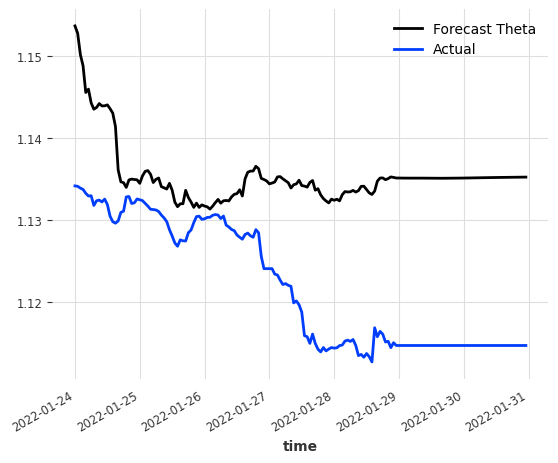

model Theta obtains MAPE: 1.20%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

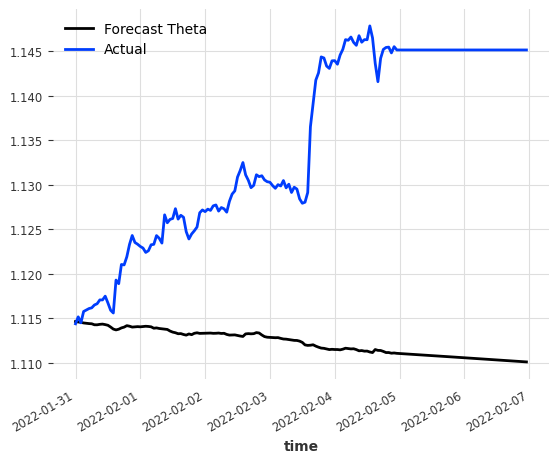

model Theta obtains MAPE: 1.96%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

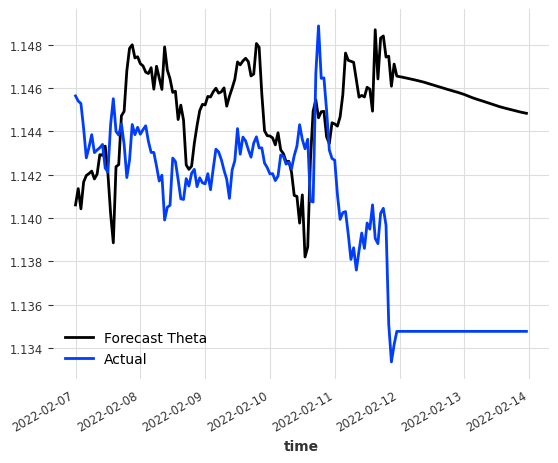

model Theta obtains MAPE: 0.51%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

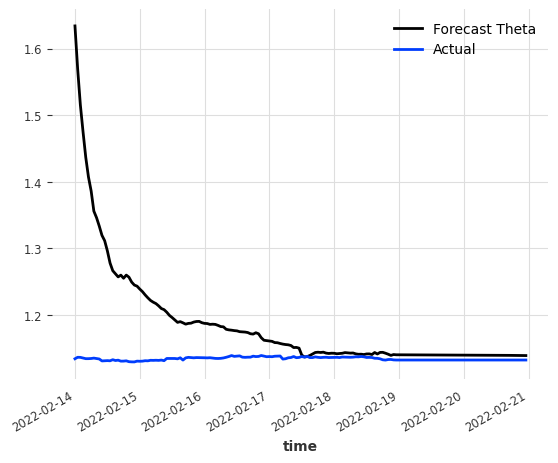

model Theta obtains MAPE: 4.46%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

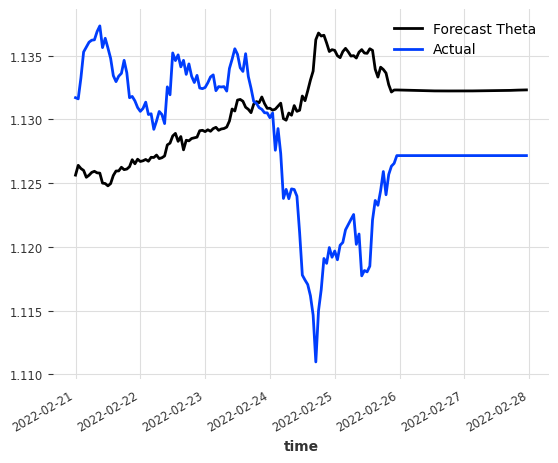

model Theta obtains MAPE: 0.62%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

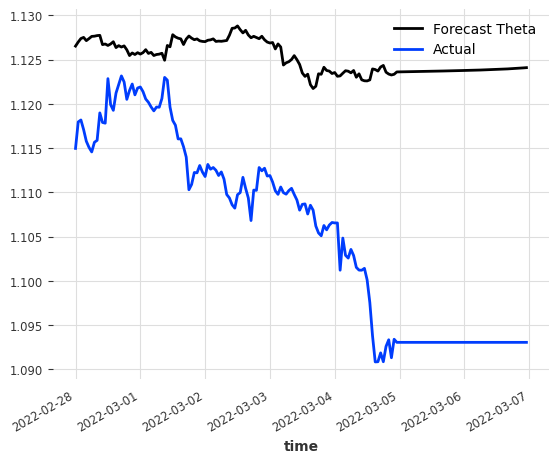

model Theta obtains MAPE: 1.77%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

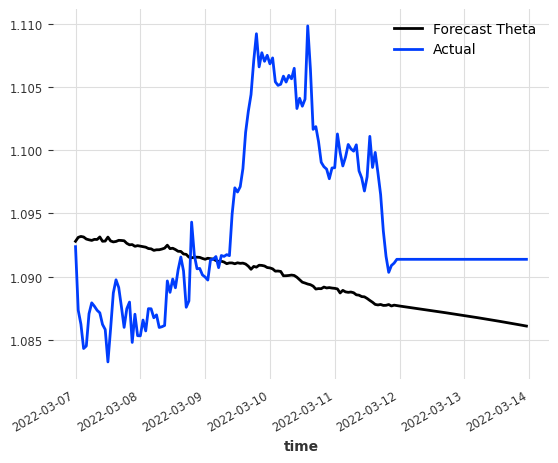

model Theta obtains MAPE: 0.63%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

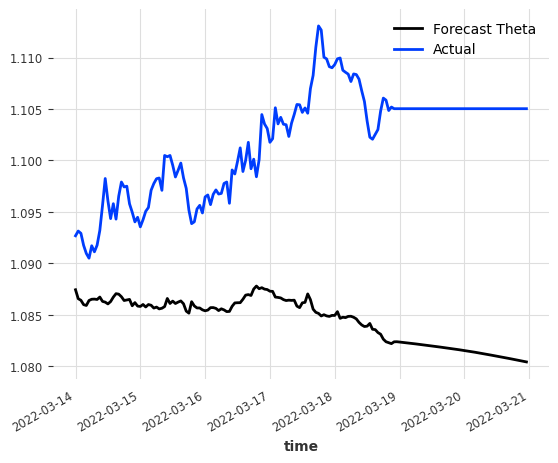

model Theta obtains MAPE: 1.57%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

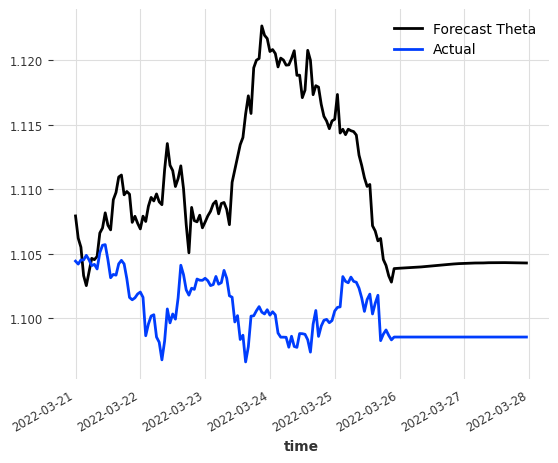

model Theta obtains MAPE: 0.83%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

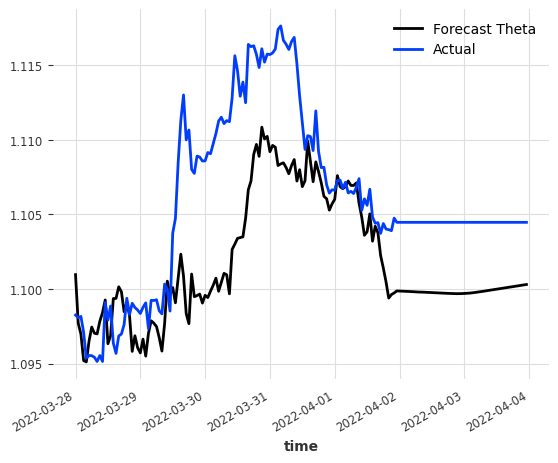

model Theta obtains MAPE: 0.41%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

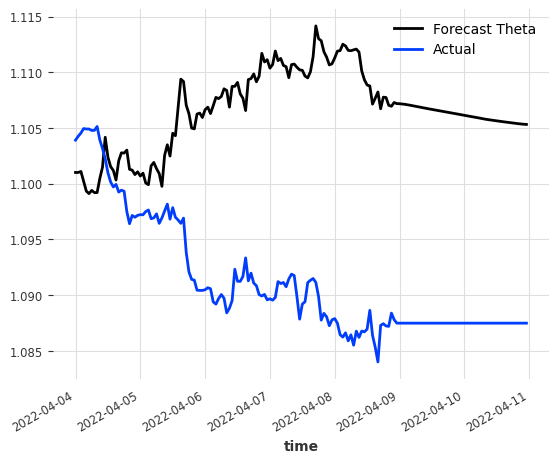

model Theta obtains MAPE: 1.46%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

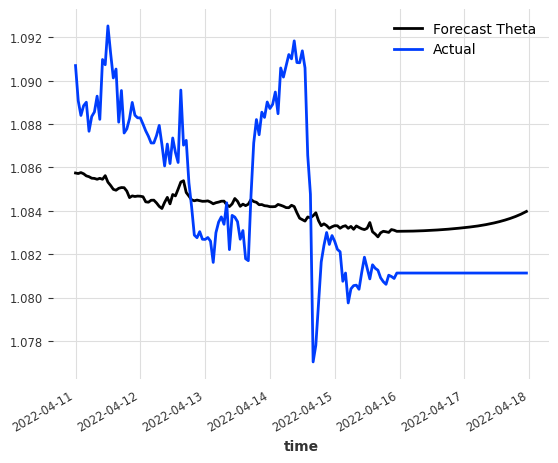

model Theta obtains MAPE: 0.25%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

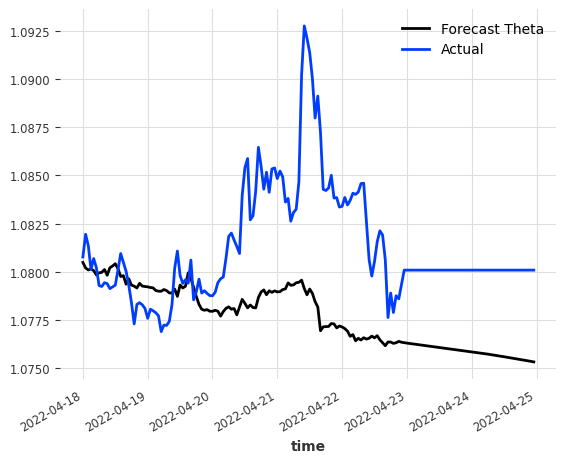

model Theta obtains MAPE: 0.36%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

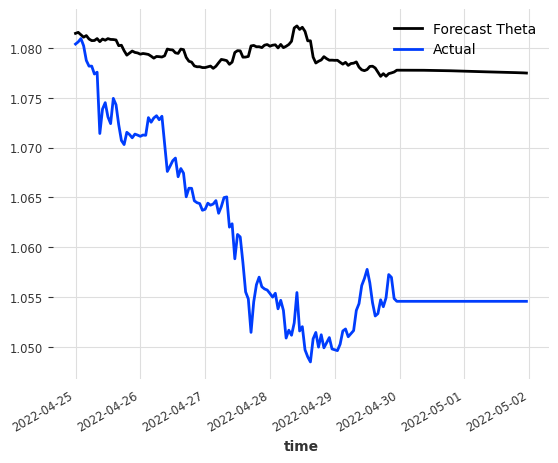

model Theta obtains MAPE: 1.81%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

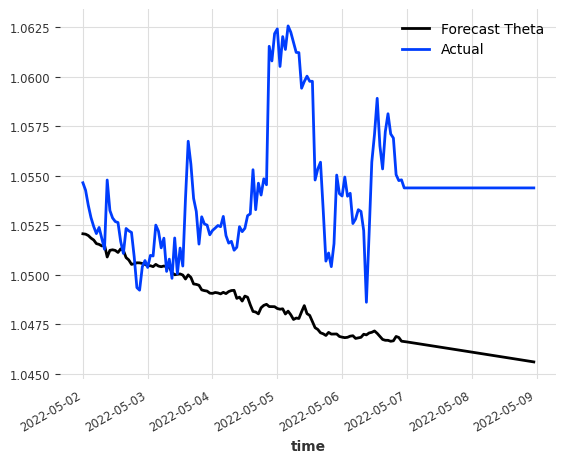

model Theta obtains MAPE: 0.58%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

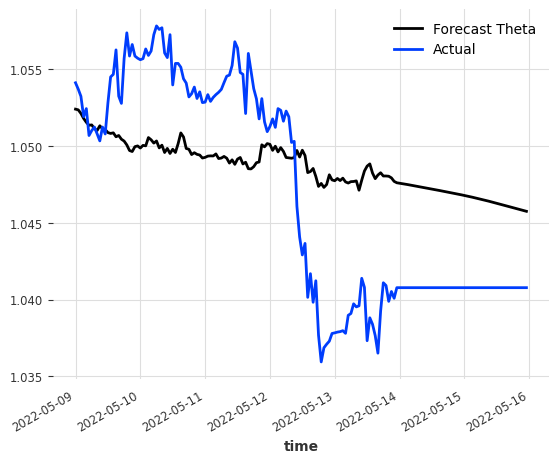

model Theta obtains MAPE: 0.53%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

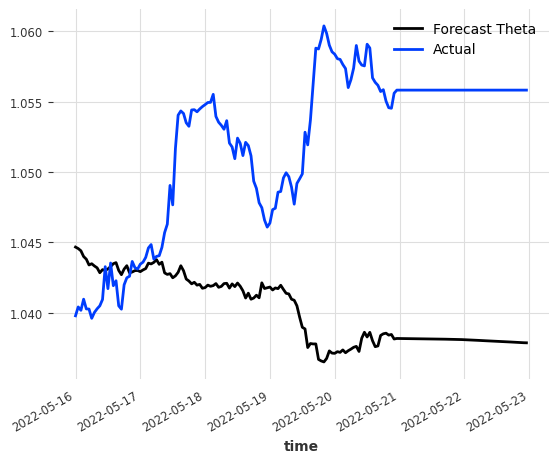

model Theta obtains MAPE: 1.17%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

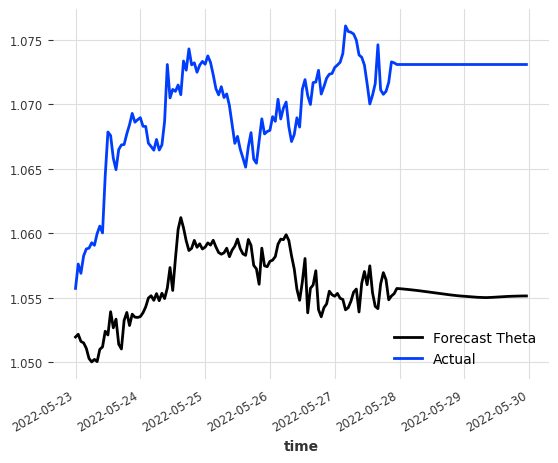

model Theta obtains MAPE: 1.36%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

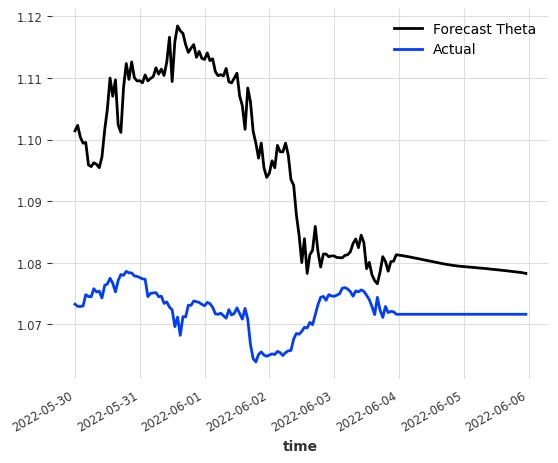

model Theta obtains MAPE: 1.93%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

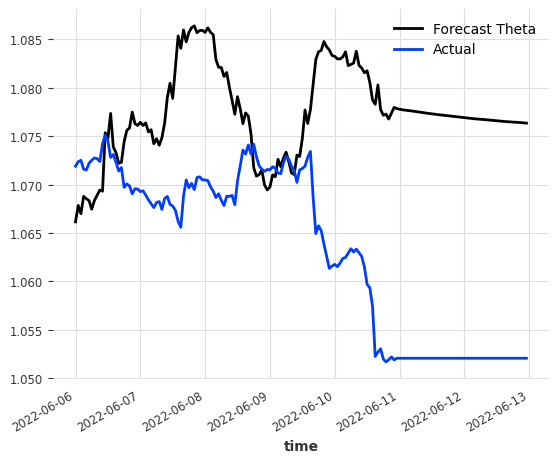

model Theta obtains MAPE: 1.40%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

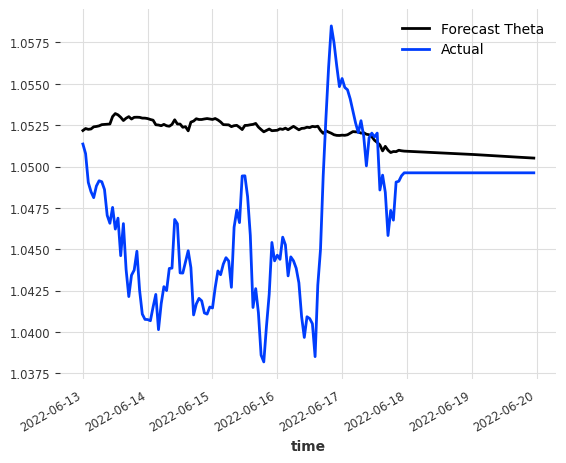

model Theta obtains MAPE: 0.50%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

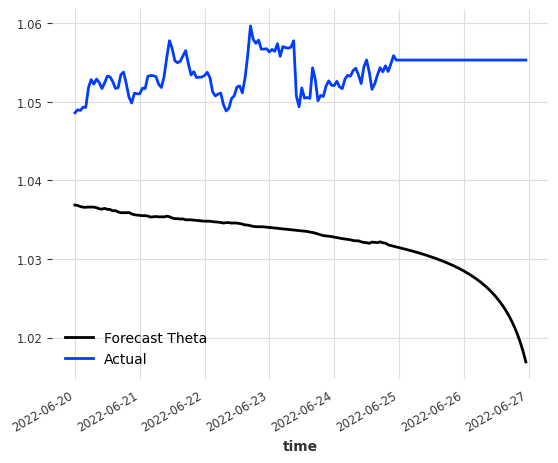

model Theta obtains MAPE: 2.04%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

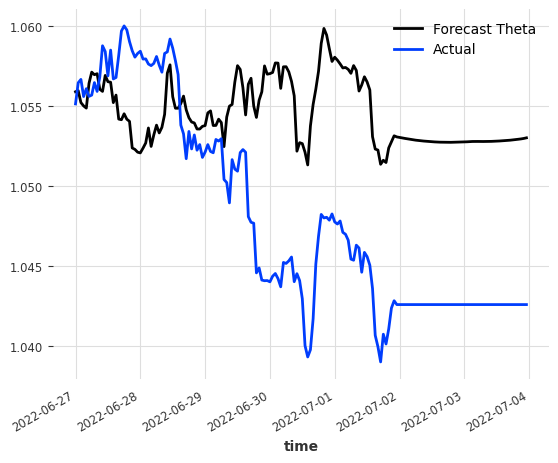

model Theta obtains MAPE: 0.74%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

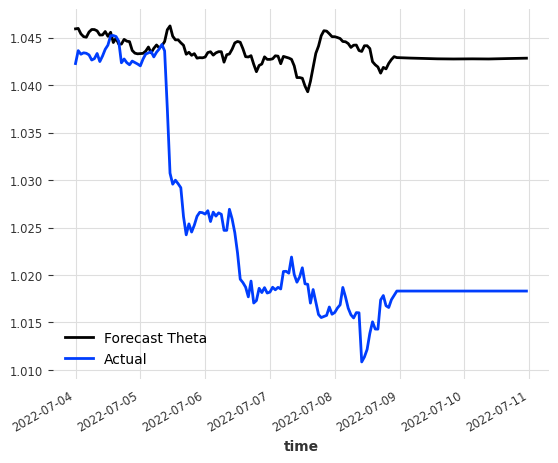

model Theta obtains MAPE: 1.87%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

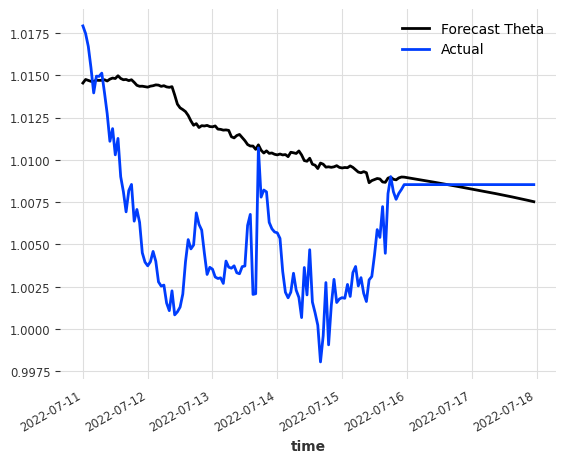

model Theta obtains MAPE: 0.48%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

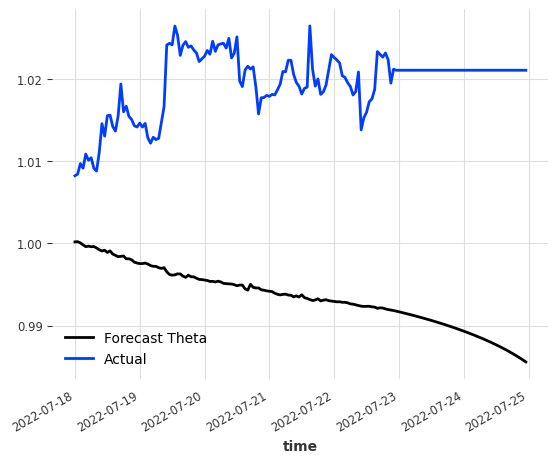

model Theta obtains MAPE: 2.55%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

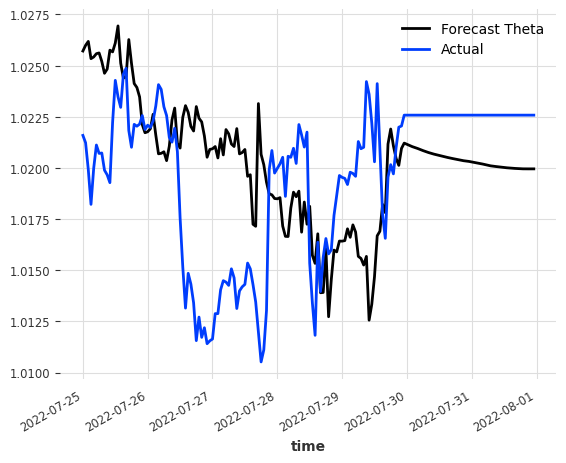

model Theta obtains MAPE: 0.36%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

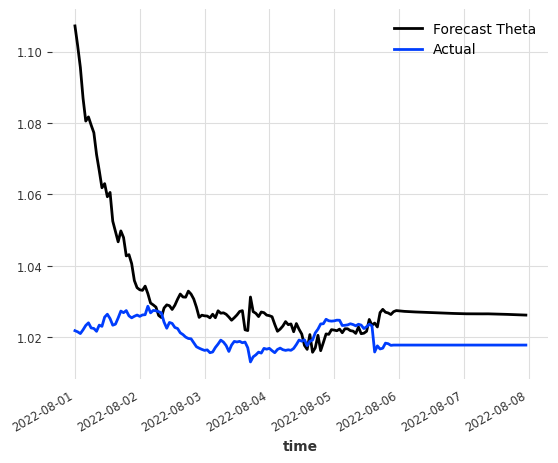

model Theta obtains MAPE: 1.16%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

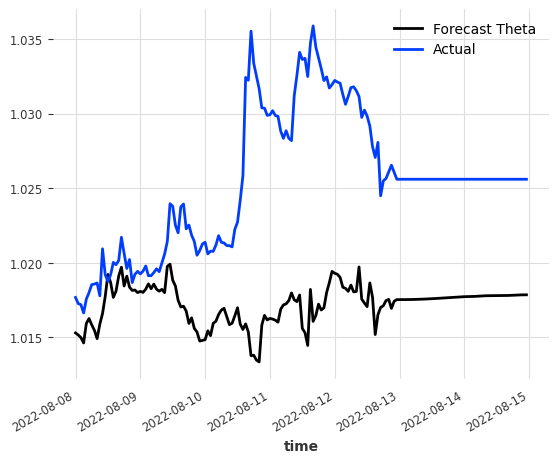

model Theta obtains MAPE: 0.80%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

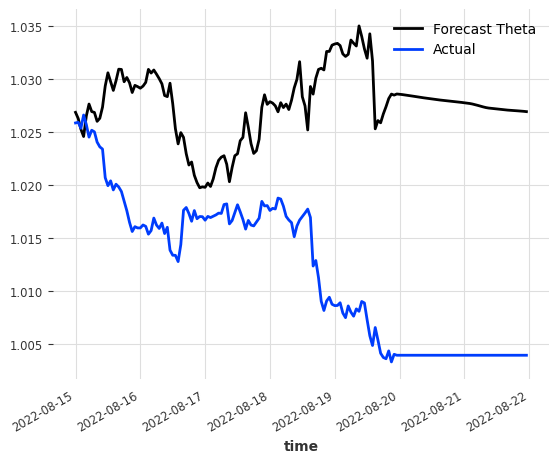

model Theta obtains MAPE: 1.55%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

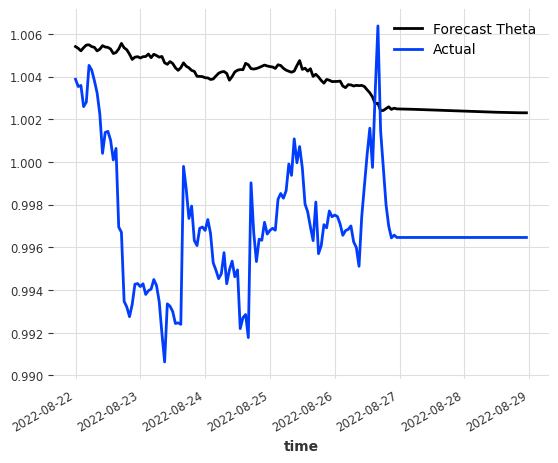

model Theta obtains MAPE: 0.68%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

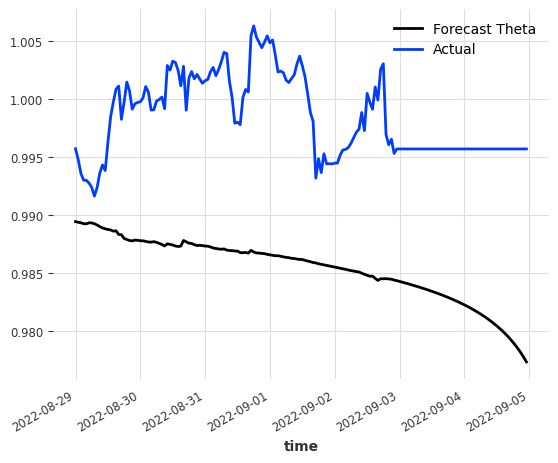

model Theta obtains MAPE: 1.30%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

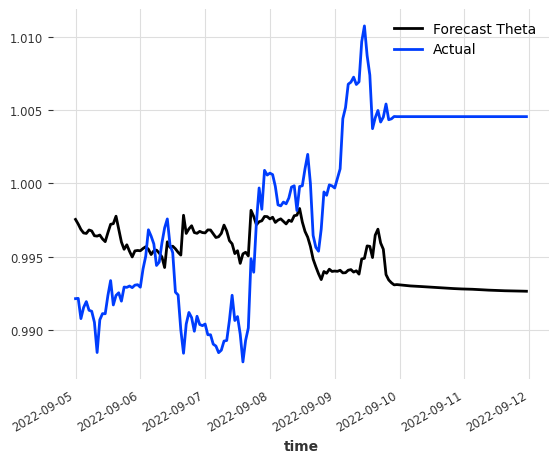

model Theta obtains MAPE: 0.71%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

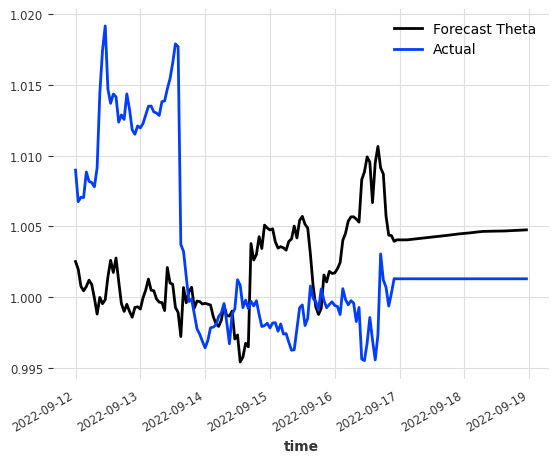

model Theta obtains MAPE: 0.59%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

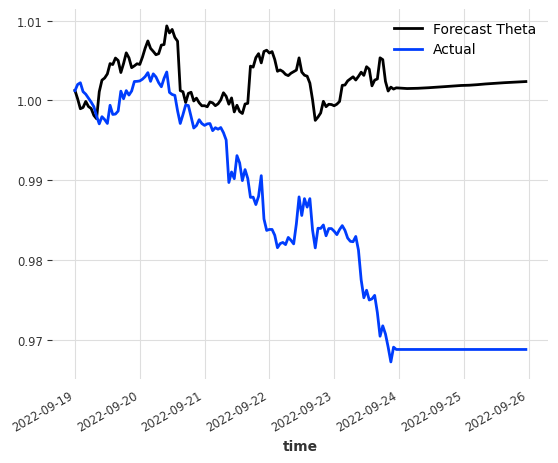

model Theta obtains MAPE: 1.85%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

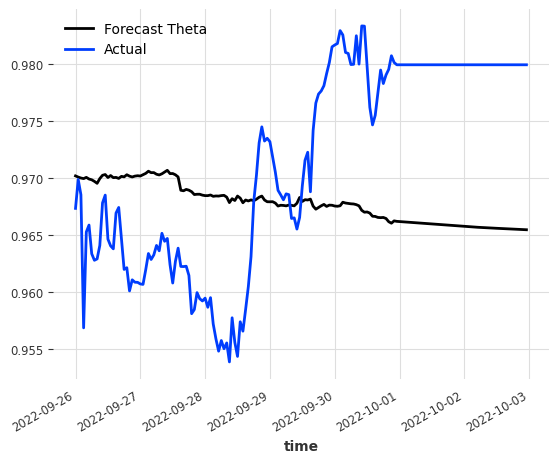

model Theta obtains MAPE: 1.01%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

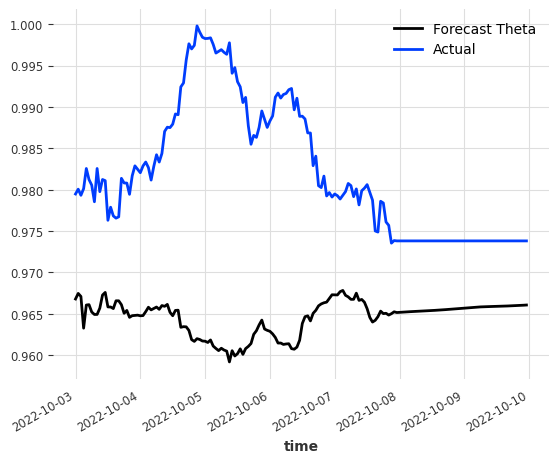

model Theta obtains MAPE: 1.78%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

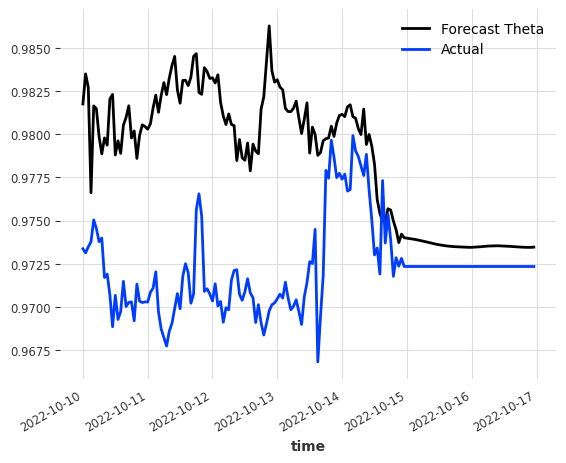

model Theta obtains MAPE: 0.66%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

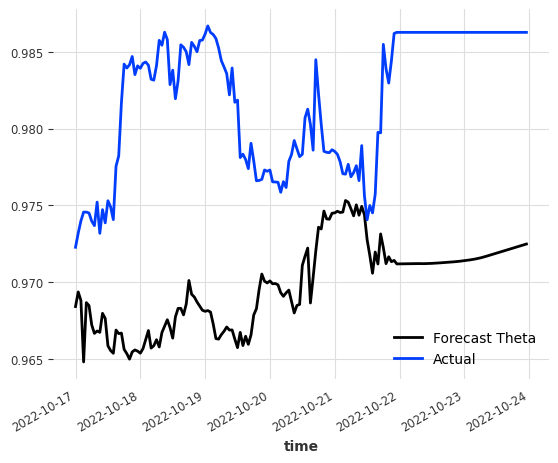

model Theta obtains MAPE: 1.23%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

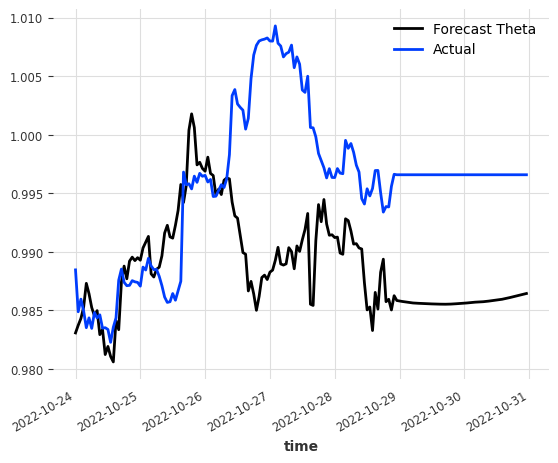

model Theta obtains MAPE: 0.82%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

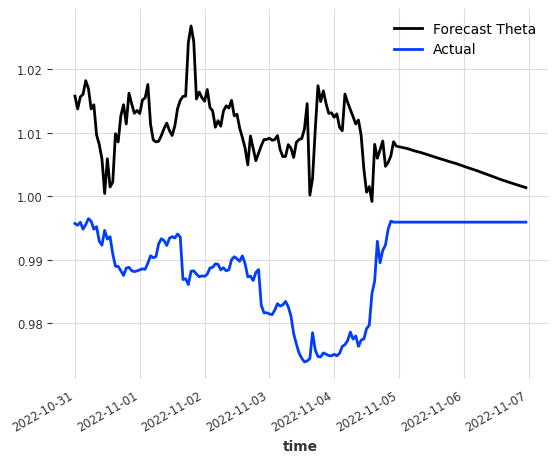

model Theta obtains MAPE: 2.04%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

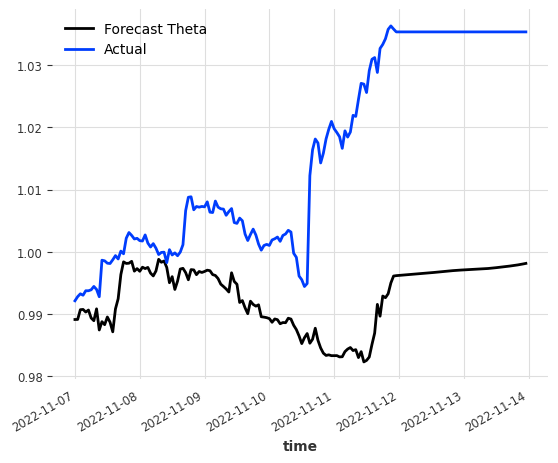

model Theta obtains MAPE: 2.20%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

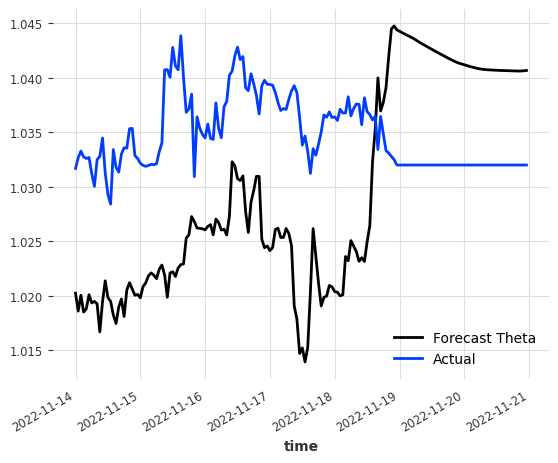

model Theta obtains MAPE: 1.13%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

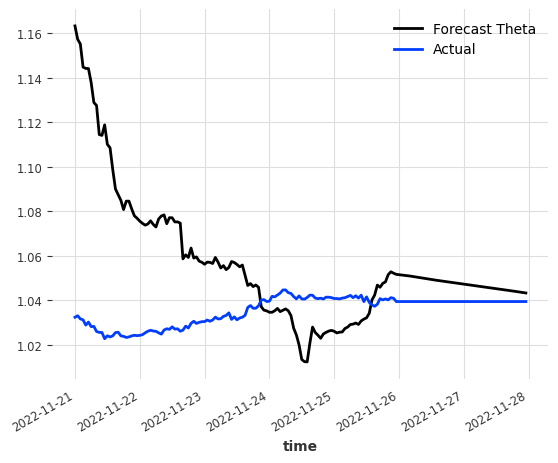

model Theta obtains MAPE: 2.63%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

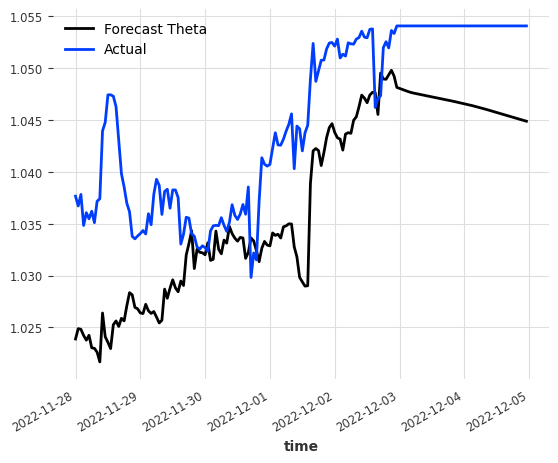

model Theta obtains MAPE: 0.75%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

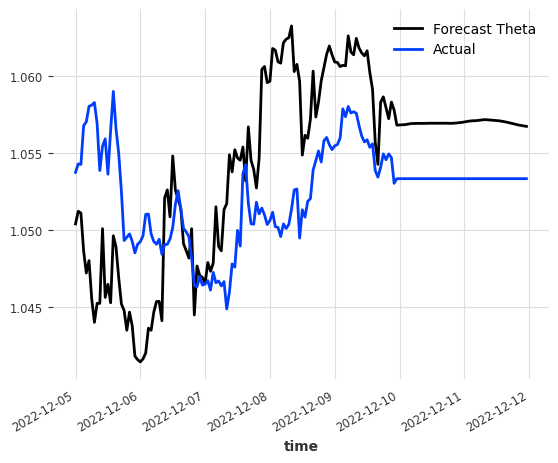

model Theta obtains MAPE: 0.47%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

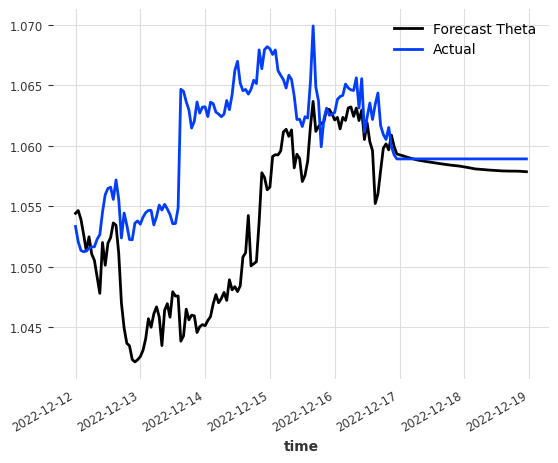

model Theta obtains MAPE: 0.53%


Theta(theta=2, seasonality_period=168, season_mode=SeasonalityMode.MULTIPLICATIVE)

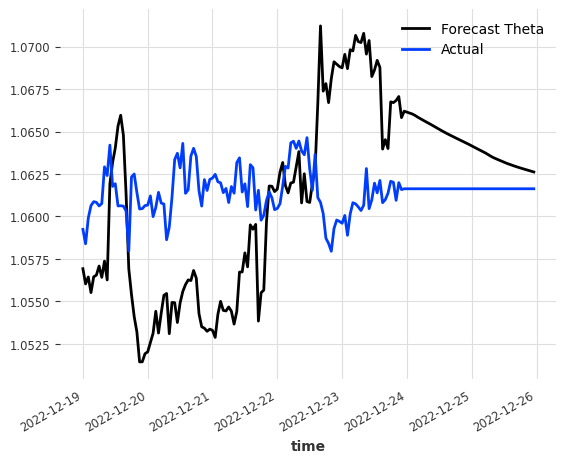

model Theta obtains MAPE: 0.45%
End of iteration 47


In [213]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

local_eur_usd_data_dict = {
    # '2010' : EURUSD_H1_2007_2023_CLOSE['2010'],
    # '2011' : EURUSD_H1_2007_2023_CLOSE['2011'],
    # '2012' : EURUSD_H1_2007_2023_CLOSE['2012'],
    # '2013' : EURUSD_H1_2007_2023_CLOSE['2013'],
    # '2014' : EURUSD_H1_2007_2023_CLOSE['2014'],
    # '2015' : EURUSD_H1_2007_2023_CLOSE['2015'],
    # '2016' : EURUSD_H1_2007_2023_CLOSE['2016'],
    # '2017' : EURUSD_H1_2007_2023_CLOSE['2017'],
    # '2018' : EURUSD_H1_2007_2023_CLOSE['2018'],
    # '2019' : EURUSD_H1_2007_2023_CLOSE['2019'],
    # '2020' : EURUSD_H1_2007_2023_CLOSE['2020'],
    # '2021' : EURUSD_H1_2007_2023_CLOSE['2021'],
    '2022': EURUSD_H1_2007_2023_CLOSE.loc['2022'],
}

for i, (key, value) in enumerate(local_eur_usd_data_dict.items()):
    local_series = TimeSeries.from_dataframe(
        value, value_cols=['Close'], freq='H', fill_missing_dates=True)
    local_series = fill_missing_values(local_series, method="ffill", limit_direction="forward")
    local_df = local_series.pd_dataframe()
    
    splitter = SlidingWindowSplitter(window_length=24*7*3, fh = np.arange(1, 169), step_length=168)
    for j, (train_idx, test_idx) in enumerate(splitter.split(local_df)):
        train_df = local_df.iloc[train_idx]
        test_df = local_df.iloc[test_idx]

        transformer = Scaler(MinMaxScaler(feature_range=(0.1, 1)))
        train_transformed = transformer.fit_transform(TimeSeries.from_dataframe(train_df))
        test_transformed = transformer.transform(TimeSeries.from_dataframe(test_df))
        
        theta = Theta(seasonality_period=24*7)
        theta.fit(train_transformed)
        fcast_theta_transformed = theta.predict(len(test_transformed))
        
        fcast_theta = transformer.inverse_transform(fcast_theta_transformed)
        fcast_theta.plot(label="Forecast {}".format('Theta'))
        
        test = transformer.inverse_transform(test_transformed)
        test.plot(label="Actual")
        # exit plot for a new plot in a new loop
        plt.legend()
        plt.show()
        print("model {} obtains MAPE: {:.2f}%".format('Theta', mape(test, fcast_theta)))
        # break
    print("End of iteration {}".format(j))



In [ ]:
local_series.plot(label="actual")  
fcast_theta.plot(label="fcast_theta")  
# fig.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter

splitter = SlidingWindowSplitter(window_length=24*7*3, fh = np.arange(1, 169), step_length=168)
for i, (train, test) in enumerate(splitter.split(local_eur_usd_data_dict['2022'])):
    if i == 2:
        # print(train)
        print(test)
    
    # print("TRAIN:", len(train), "TEST:", len(test))
# TEST: 504 - 671
# TEST: 672 - 839
# print(list(splitter.split(local_eur_usd_data_dict['2022'])))

In [173]:
print(local_eur_usd_data_dict['2022'].size)

6228
